In [1]:
import pandas as pd 
import numpy as np
import pygam
import matplotlib.pyplot as plt

from pygam import LogisticGAM, s, f, l, te
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from tabulate import tabulate 

#### Remove One Record
In the test set, there is one record with 'p_age_first_offense' == 0. Removed

In [2]:
train_pd = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/model_data/train.csv")
test_pd = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/model_data/test.csv")
test_pd = test_pd[test_pd['p_age_first_offense'] != 0]

In [3]:
x_train, y_train = train_pd.values[:,:-1], train_pd.values[:,-1]
x_test, y_test = test_pd.values[:,:-1], test_pd.values[:,-1]

In [4]:
cols = train_pd.columns[:-1]

In [5]:
cols

Index(['sex', 'p_current_age', 'p_age_first_offense', 'p_charge', 'p_jail30',
       'p_prison', 'p_probation', 'p_juv_fel_count', 'p_felprop_violarrest',
       'p_murder_arrest', 'p_felassault_arrest', 'p_misdemassault_arrest',
       'p_famviol_arrest', 'p_sex_arrest', 'p_weapons_arrest',
       'fail_appear_two_yr', 'fail_appear_two_plus', 'current_violent',
       'current_violent20', 'pending_charge', 'prior_conviction_F',
       'prior_conviction_M', 'violent_conviction', 'total_convictions',
       'p_arrest', 'p_property', 'p_traffic', 'p_drug', 'p_dui', 'p_domestic',
       'p_stalking', 'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass'],
      dtype='object')

### 1. Default GAM

#### sex: categorical; others: splines

In [7]:
gam = LogisticGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + f(9) + s(10) + s(11) + s(12)
                  + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24)
                   + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34)).fit(x_train, y_train)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     153.844
Link Function:                        LogitLink Log Likelihood:                                  -881.9366
Number of Samples:                         1563 AIC:                                             2071.5612
                                                AICc:                                            2105.8595
                                                UBRE:                                               3.4041
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1819
Feature Function                  Lam

C:\Users\binha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  after removing the cwd from sys.path.


In [8]:
gam.accuracy(x_train, y_train), gam.accuracy(x_test, y_test)

(0.7063339731285988, 0.6370967741935484)

#### Cross Validation

In [6]:
combined = np.r_[train_pd, test_pd]
X, Y = combined[:,:-1], combined[:,-1]

Text(0,0.5,'True Positive Rate')

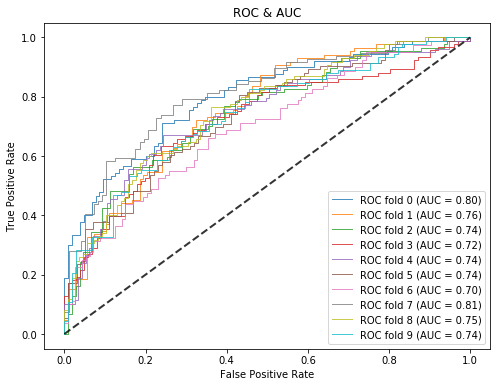

In [10]:
cv = KFold(n_splits=10, random_state=816, shuffle=True)
train_acc = []
test_acc = []

i = 0
plt.figure(figsize=(8,6))
for train, test in cv.split(X, Y):
    
    ## data & classifier
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    train_acc.append(gam.accuracy(X_train, Y_train))
    test_acc.append(gam.accuracy(X_test, Y_test))
    prob = gam.predict_proba(X_test)
    
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [11]:
np.mean(train_acc), np.mean(test_acc)

(0.693023098619042, 0.6930105229421505)

#### Partial Dependence

- For each feature, we need to get integer values.

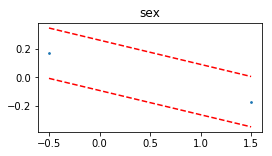

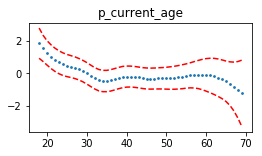

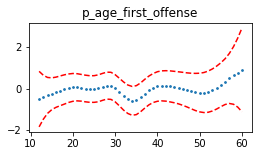

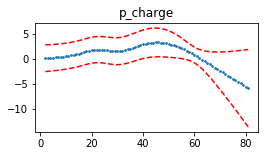

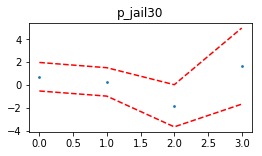

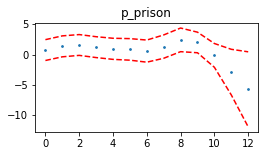

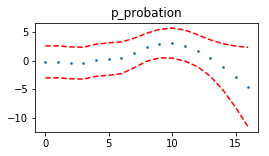

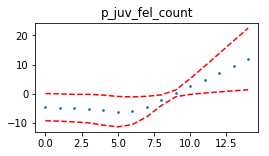

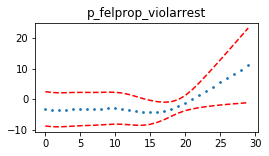

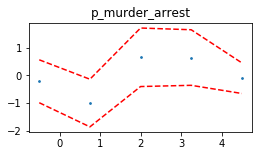

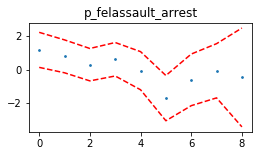

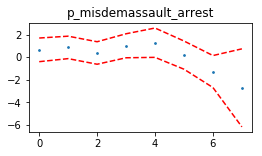

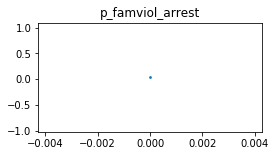

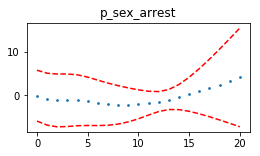

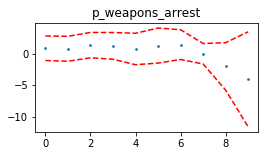

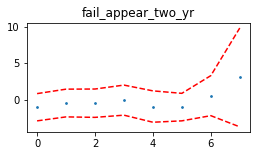

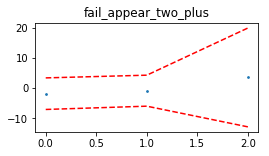

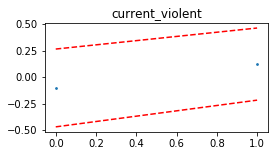

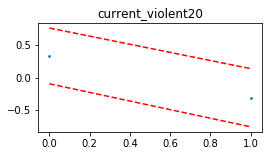

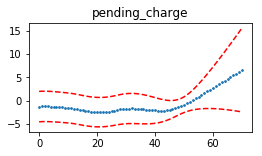

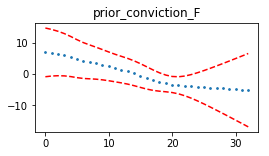

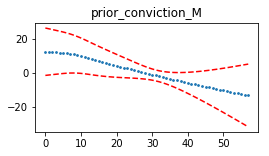

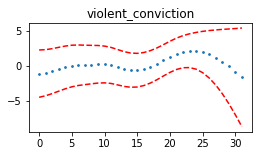

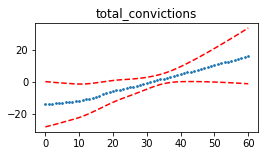

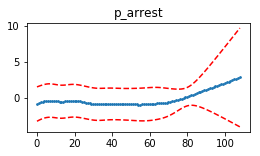

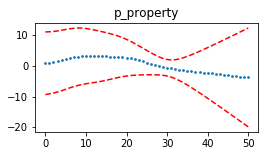

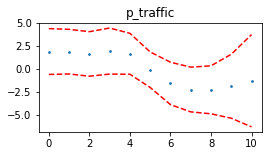

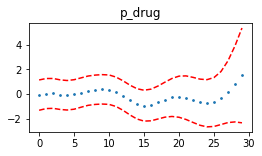

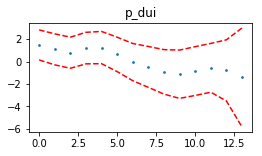

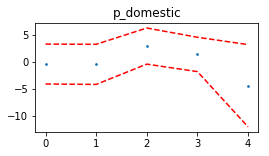

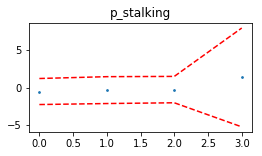

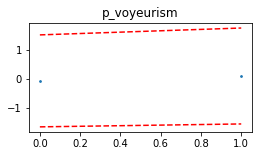

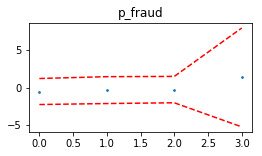

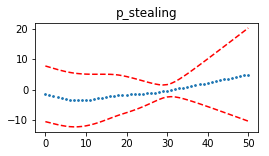

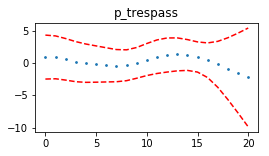

In [12]:
pdep = []

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    
    feature = x_train[:,i]
    upper, lower = np.max(feature), np.min(feature)
    XX = gam.generate_X_grid(term = i, n=(upper - lower + 1))
    
    pdep.append(gam.partial_dependence(term = i, X=XX, width=0.95)[0])
    confi = gam.partial_dependence(term = i, X=XX, width=0.95)[1]
    
    plt.figure(figsize = (4,2))
    
    plt.scatter(XX[:, term.feature], pdep[i], s= 3)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')

    #plt.plot(XX[:, term.feature], pdep[i])
    #plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(train_pd.columns[i])
    plt.show()

### Try to replicate the prediction process

In [125]:
pdep

[array([ 0.17149786, -0.17149785]),
 array([ 1.86648413,  1.54118866,  1.26447052,  1.03196551,  0.83986802,
         0.68660675,  0.57116897,  0.48927915,  0.42361048,  0.35357334,
         0.26213346,  0.14647798,  0.00734943, -0.14964847, -0.29946701,
        -0.41219626, -0.46511784, -0.46427959, -0.42292093, -0.35551845,
        -0.28149762, -0.2215211 , -0.19174371, -0.1902888 , -0.21077186,
        -0.24570233, -0.28316543, -0.31014032, -0.31744538, -0.31125605,
        -0.30158696, -0.29586602, -0.29117414, -0.28200547, -0.26386683,
        -0.23631571, -0.19992228, -0.1566413 , -0.11396591, -0.08077386,
        -0.06445069, -0.06641306, -0.08658543, -0.12506311, -0.18262478,
        -0.26021999, -0.35914101, -0.48205107, -0.63195613, -0.81028537,
        -1.0121609 , -1.23112805]),
 array([-0.50479329, -0.41309949, -0.32612166, -0.24548425, -0.17172247,
        -0.10277476, -0.03632565,  0.02340661,  0.06259203,  0.06751527,
         0.04223867,  0.00728898, -0.01686711, -0.01

In [126]:
pred = {}
for i in range(len(cols)):
    
    feature = cols[i]
    feature_values = train_pd[feature].values
    upper, lower = np.max(feature_values), np.min(feature_values)
    
    stumps = np.linspace(lower, upper, (upper-lower+1))
    values = pdep[i]
    
    a = {}
    for b in range(len(values)):
        a.update({stumps[b]:values[b]})
    
    pred.update({feature:a})

In [127]:
pred

{'sex': {0.0: 0.1714978550947861, 1.0: -0.1714978495429033},
 'p_current_age': {18.0: 1.8664841251780764,
  19.0: 1.5411886638231782,
  20.0: 1.2644705238772218,
  21.0: 1.0319655147205107,
  22.0: 0.8398680237914922,
  23.0: 0.6866067507611934,
  24.0: 0.5711689733587848,
  25.0: 0.4892791525413439,
  26.0: 0.4236104821775751,
  27.0: 0.3535733393640882,
  28.0: 0.26213345593475457,
  29.0: 0.14647798267248696,
  30.0: 0.007349425097459061,
  31.0: -0.14964847294366465,
  32.0: -0.2994670142982547,
  33.0: -0.4121962634871891,
  34.0: -0.46511784140708995,
  35.0: -0.46427959445755046,
  36.0: -0.42292092541390636,
  37.0: -0.35551844780122543,
  38.0: -0.28149761814350355,
  39.0: -0.22152110371446795,
  40.0: -0.19174370996760823,
  41.0: -0.19028879507546156,
  42.0: -0.21077185539032667,
  43.0: -0.24570233037343395,
  44.0: -0.28316543192173926,
  45.0: -0.31014031504113015,
  46.0: -0.3174453848199433,
  47.0: -0.3112560466763147,
  48.0: -0.30158695611082964,
  49.0: -0.2958660

In [128]:
prediction = np.zeros(len(test_pd))
ind = 0

for i in range(len(test_pd)):
    summation = 0
    
    for j in range(len(cols)):
        feature = cols[j]
        test = test_pd.iloc[i,:][feature]
        if test not in pred[feature]:
            ind += 1
            continue
        summation += pred[feature][test]
    
    prediction[i] = summation

In [129]:
np.mean((prediction > 0.5) == y_test)

0.6021505376344086

### Solve Extropolation

#### Accuracy

In [7]:
def accuracy(X, y):
    
    X = pd.DataFrame(X, columns=cols)
    prediction = np.zeros(len(X))
    
    for i in range(len(X)):
        summation = 0    
        for j in range(len(cols)):
            feature = cols[j]
            test = X.iloc[i,:][feature]
            summation += pred[feature][test]
    
        prediction[i] = summation
    
    return prediction

#### Fit Model

In [8]:
cols

Index(['sex', 'p_current_age', 'p_age_first_offense', 'p_charge', 'p_jail30',
       'p_prison', 'p_probation', 'p_juv_fel_count', 'p_felprop_violarrest',
       'p_murder_arrest', 'p_felassault_arrest', 'p_misdemassault_arrest',
       'p_famviol_arrest', 'p_sex_arrest', 'p_weapons_arrest',
       'fail_appear_two_yr', 'fail_appear_two_plus', 'current_violent',
       'current_violent20', 'pending_charge', 'prior_conviction_F',
       'prior_conviction_M', 'violent_conviction', 'total_convictions',
       'p_arrest', 'p_property', 'p_traffic', 'p_drug', 'p_dui', 'p_domestic',
       'p_stalking', 'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass'],
      dtype='object')

In [9]:
gam = LogisticGAM(f(0) + s(1, 100) + s(2, 100) + s(3, 50) + s(4, 50) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10, 50) + s(11) + s(12)
                  + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24)
                  + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34)).fit(x_train, y_train)

In [10]:
pdep = []
for i in range(x_train.shape[1]):
    feature = combined[:,i]
    upper, lower = np.max(feature), np.min(feature)
    pdep.append(np.zeros(upper - lower + 1))

In [11]:
for i, term in enumerate(gam.terms):
    
    if term.isintercept:
        continue
    
    ## subset features
    feature, sub_feature = combined[:,i], x_train[:,i]
    
    ## calcualte range values
    feature_upper, feature_lower = np.max(feature), np.min(feature)
    sub_feature_upper, sub_feature_lower = np.max(sub_feature), np.min(sub_feature)
    
    ## calculate partial dependence
    XX = gam.generate_X_grid(term = i, n=(sub_feature_upper - sub_feature_lower + 1))
    p = gam.partial_dependence(term = i, X=XX, width=0.95)[0]
        
    ## add zeros if range of sub feature values is smaller than the range of original feature value
    leading_zeros = sub_feature_lower - feature_lower
    p = np.append(np.zeros(leading_zeros), p)
    
    rear_zeros = feature_upper - sub_feature_upper
    p = np.append(p, np.zeros(rear_zeros))
    
    ## add to the final list
    pdep[i] += p

In [12]:
pred = {}

for i in range(len(cols)):
    
    feature_name = cols[i]
    feature = combined[:,i]
    upper, lower = np.max(feature), np.min(feature)
    stumps = np.linspace(lower, upper, (upper-lower+1))
    values = pdep[i]
    
    a = {}
    for b in range(len(values)):
        a.update({stumps[b]:values[b]})
    
    pred.update({feature_name:a})

#### Cross Validation

0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'True Positive Rate')

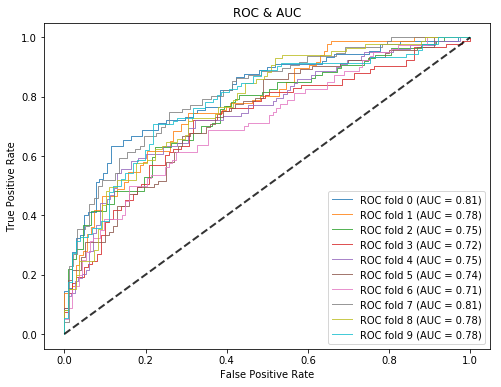

In [13]:
cv = KFold(n_splits=10, random_state=816, shuffle=True)
train_acc = []
test_acc = []

i = 0
plt.figure(figsize=(8,6))
for train, test in cv.split(X, Y):
    
    print(i)
    
    ## data & classifier
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    
    train_pred = accuracy(X_train, Y_train)
    test_pred = accuracy(X_test, Y_test)

    train_acc.append(np.mean((train_pred > 0.5) == Y_train))
    test_acc.append(np.mean((test_pred > 0.5) == Y_test))
    
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [18]:
train_acc

[0.6840896036760482,
 0.6898334290637564,
 0.6927053417576106,
 0.6950028719126938,
 0.6892590465249856,
 0.6963260619977037,
 0.6928817451205511,
 0.6917336394948336,
 0.6911595866819747,
 0.6917336394948336]

In [19]:
test_acc

[0.7577319587628866,
 0.7061855670103093,
 0.6804123711340206,
 0.6597938144329897,
 0.711340206185567,
 0.6476683937823834,
 0.6787564766839378,
 0.689119170984456,
 0.694300518134715,
 0.689119170984456]

In [20]:
np.mean(train_acc), np.mean(test_acc)

(0.6914724965724991, 0.6914427648095721)

In [21]:
np.max(test_acc)

0.7577319587628866